# 変分ベイズ

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
from mpl_toolkits.mplot3d import Axes3D
from scipy import genfromtxt
from scipy.special import gamma, digamma
%matplotlib inline

eps = np.finfo(float).eps

### ガウス分布の作成

In [2]:
def makeGaussian(mu, sig):
    def func(x):
        y = np.exp(-(x - mu)**2/(2*sig)) / np.sqrt(2*np.pi*sig)
        return y
    return func

def makeMultiGaussian(mu, sig):
    def func(x):
        y = np.exp(-(x-mu).T.dot(np.linalg.inv(sig)).dot(x-mu)/2) / ((2*np.pi)**(2/2)*np.sqrt(np.linalg.det(sig)))
        return y
    return func

### ガンマ分布の作成，及び ガウス-ガンマ分布の作成

In [3]:
def makeGammaDist(a, b):
    def gammaDist(x):
        return b**a*x**(a-1)*np.exp(-b*x) / gamma(a)
    return gammaDist

def gaussGammaDist(tau, mu, a=1, b=1, m=0, l=1):
    pgm = makeGammaDist(a, b)
    pga = makeGaussian(m, (l*tau)**-1) 
    
    return pgm(tau)*pga(mu)

メッシュの準備

In [1731]:
m = 100
x = np.linspace(-10, 10, m)
y = np.linspace(-10, 10, m)
xx, yy = np.meshgrid(x, y)

tau = np.linspace(eps, 5, 100)
mu = np.linspace(-5, 5, 100)
tt, mm = np.meshgrid(tau, mu)

---

## 分解による近似(平均場近似)

1次元正規分布の掛け算結果

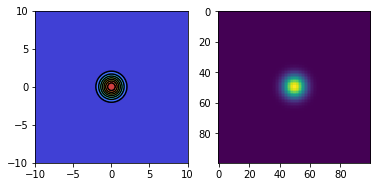

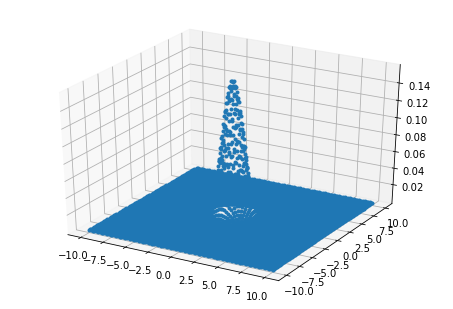

In [1732]:
norm1 = makeGaussian(0, 1)
norm2 = makeGaussian(0, 1)
plt.figure(0)
plt.subplot(121)
plt.contourf(xx, yy, norm1(xx)*norm2(yy), 8, alpha=.75, cmap='jet')
plt.contour(xx, yy, norm1(xx)*norm2(yy), 8, colors='black', linewidth=.5)
plt.gca().set_aspect('equal')
plt.subplot(122)
plt.imshow(norm1(xx)*norm2(yy))
# グラフ作成
ax = Axes3D(plt.figure(1))
ax.plot(xx.reshape(m**2), yy.reshape(m**2), (norm1(xx)*norm2(yy)).reshape(m**2), ".")

$q\left( \boldsymbol{z} \right) = \Pi q_i\left( \boldsymbol{z_i} \right)$ として  
2次元正規分布を1次元正規分布の同時確率として近似する．

2次元正規分布の作成

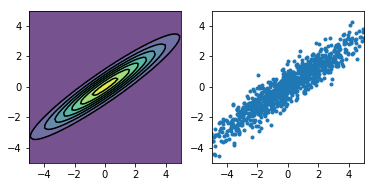

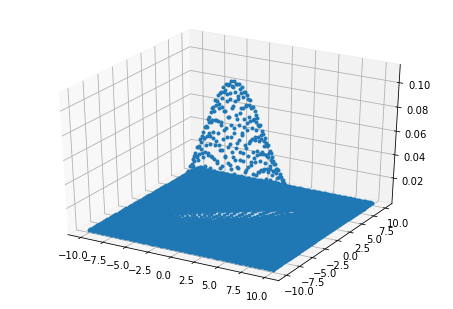

In [1733]:
mu = np.array([0, 0]).reshape((2, 1))
sig = np.array([[6, 4], [4, 3]])

norm3 = makeMultiGaussian(mu, sig)
X = np.concatenate([xx.reshape(1, m**2), yy.reshape(1, m**2)], axis=0)
Z = np.array([norm3(xi.reshape(2,1)) for xi in X.T])

plt.figure(0)
plt.subplot(121)
plt.contourf(xx, yy, Z.reshape(m,m), 8, alpha=.75)
plt.contour(xx, yy, Z.reshape(m,m), 8, colors='black', linewidth=.5)
plt.gca().set_aspect('equal')
plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.subplot(122)
Xs = np.random.multivariate_normal(mu.reshape(2), sig, 1000)
plt.plot(Xs[:,0], Xs[:,1], ".")
plt.gca().set_aspect('equal')
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# グラフ作成
ax = Axes3D(plt.figure(1))
ax.plot(xx.reshape(m**2), yy.reshape(m**2), Z.reshape(m**2), ".")

1次元正規分布初期値を作成  
目標との比較

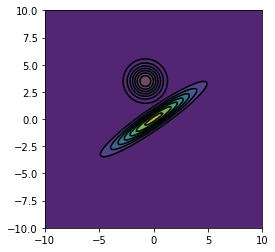

In [1734]:
m1, m2 = np.random.uniform(-5, 5, 2)
norm1 = makeGaussian(m1, 1)
norm2 = makeGaussian(m2, 1)
plt.figure(0)
plt.contourf(xx, yy, norm1(xx)*norm2(yy), 8, alpha=.75)
plt.contour(xx, yy, norm1(xx)*norm2(yy), 8, colors='black', linewidth=.5)
plt.contourf(xx, yy, Z.reshape(m,m), 8, alpha=.75)
plt.contour(xx, yy, Z.reshape(m,m), 8, colors='black', linewidth=.5)
plt.gca().set_aspect('equal')

分解した各分布を変分推論の手法によって更新  
最終結果を表示する

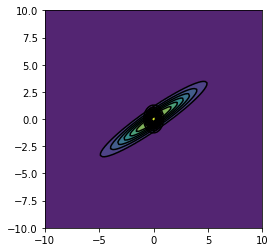

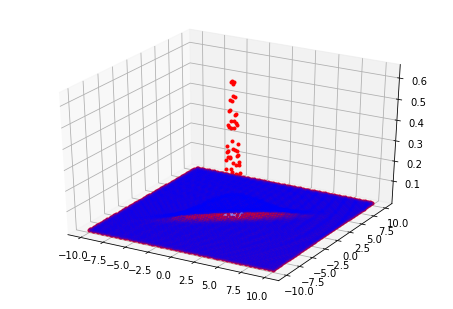

In [1735]:
#mu_s, sig_s = np.mean(Xs.T, axis=1), np.cov(Xs.T)
for i in range(50):
    m1 = mu[0] - 1/sig[0,0]*sig[0,1]*(m2 - mu[1])
    norm1 = makeGaussian(m1, 1/sig[0,0])
    m2 = mu[1] - 1/sig[1,1]*sig[0,1]*(m1 - mu[0])
    norm2 = makeGaussian(m2, 1/sig[1,1])

plt.figure(0)
plt.contourf(xx, yy, norm1(xx)*norm2(yy), 10, alpha=.75)
plt.contour(xx, yy, norm1(xx)*norm2(yy), 10, colors='black', linewidth=.5)
plt.contourf(xx, yy, Z.reshape(m,m), 8, alpha=.75)
plt.contour(xx, yy, Z.reshape(m,m), 8, colors='black', linewidth=.5)
plt.gca().set_aspect('equal')

# グラフ作成
ax = Axes3D(plt.figure(2))
ax.plot(xx.reshape(m**2), yy.reshape(m**2), (norm1(xx)*norm2(yy)).reshape(m**2), "r.")
ax.plot(xx.reshape(m**2), yy.reshape(m**2), Z.reshape(m**2), "b.", alpha=0.2)

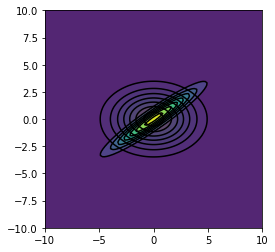

In [1736]:
norm1 = makeGaussian(mu[0,0], sig[0,0])
norm2 = makeGaussian(mu[1,0], sig[1,1])
plt.figure(0)
plt.contourf(xx, yy, norm1(xx)*norm2(yy), 8, alpha=.75)
plt.contour(xx, yy, norm1(xx)*norm2(yy), 8, colors='black', linewidth=.5)
plt.contourf(xx, yy, Z.reshape(m,m), 8, alpha=.75)
plt.contour(xx, yy, Z.reshape(m,m), 8, colors='black', linewidth=.5)
plt.gca().set_aspect('equal')

---

## 1変数ガウス

真の事前分布パラメータ

In [1737]:
tau = np.linspace(eps, 1, 100)
mu = np.linspace(-2, 2, 100)
tt, mm = np.meshgrid(tau, mu)

In [1738]:
mu_D, sig_D = 0, 1.5

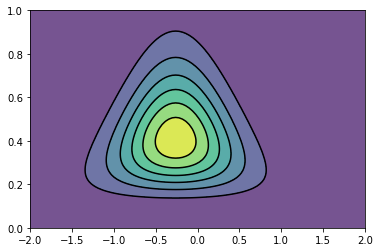

In [1739]:
Ns = 10
Xs = np.random.normal(mu_D, sig_D, Ns)
a_t = Ns/2
b_t = (Xs**2).sum() / 2
mu_t = Xs.sum() / Ns
l_t = Ns

plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

事後分布の推定パラメータ

事前分布が幾つかサンプリングをしたあとの事後分布の場合

In [1740]:
# 事前分布のパラメータ
Np = 5
Xp = np.random.normal(mu_D, sig_D, Np)
a_prior = Np/2
b_prior = (Xp**2).sum() / 2
mu_prior = Xp.sum() / Np
l_prior = Np

In [1741]:
# 変分ベイズによる事後分布の計算
Et = 0
for i in range(10):
    if Et == 0: Et = a_prior / b_prior
    else: Et = a_vb1 / b_vb1
    mu_vb1 = (Xs.sum() + mu_prior) / (Ns + l_prior)
    l_vb1 = Et * (Ns + l_prior)
    
    a_vb1 = a_prior + (Ns+1) / 2
    b_vb1 = b_prior + ((Xs**2).sum() + l_prior*mu_prior**2) / 2
    b_vb1 += (Ns + l_prior) * (mu_vb1**2 + l_vb1**-1) / 2
    b_vb1 += - (Xs.sum() + l_prior*mu_prior) * mu_vb1
    
print(mu_D, sig_D, "＝＝＞", mu_vb1, (b_vb1/a_vb1)**0.5)
print(a_vb1, "<==>", a_t)
print(b_vb1, "<==>", b_t)
print(mu_vb1, "<==>", mu_t)
print(l_vb1, "<==>", l_t)


0 1.5 ＝＝＞ -0.235980466794 1.5526196196
8.0 <==> 5.0
19.2850214653 <==> 11.0614096453
-0.235980466794 <==> -0.262244953753
6.22244575749 <==> 10


事前分布が無情報事前分布の場合

In [1742]:
# 変分ベイズによる事後分布の計算
Et = 0
for i in range(10):
    if Et == 0: Et = Xs.var()**-1
    else: Et = a_vb2 / b_vb2
    mu_vb2 = Xs.sum()/Ns
    l_vb2 = Et * Ns
    
    a_vb2 = (Ns+1) / 2
    b_vb2 = (Xs**2).sum() / 2
    b_vb2 += Ns * (mu_vb2**2 + l_vb2**-1) / 2
    b_vb2 += -Xs.sum() * mu_vb2
    
print(mu_D, sig_D, "＝＝＞", mu_vb2, (b_vb2/a_vb2)**0.5)
print(a_vb2, "<==>", a_t)
print(b_vb2, "<==>", b_t)
print(mu_vb2, "<==>", mu_t)
print(l_vb2, "<==>", l_t)

0 1.5 ＝＝＞ -0.262244953753 1.46407291939
5.5 <==> 5.0
11.7893023231 <==> 11.0614096453
-0.262244953753 <==> -0.262244953753
4.66524638123 <==> 10


結果の比較  
左：事前分布が無情報で無い  
右：事前分布が無情報事前分布

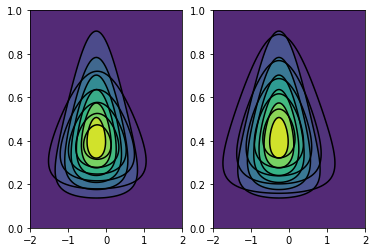

In [1743]:
plt.subplot(121)
plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_vb1,b_vb1,mu_vb1,l_vb1), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_vb1,b_vb1,mu_vb1,l_vb1), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

plt.subplot(122)
plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_vb2,b_vb2,mu_vb2,l_vb2), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_vb2,b_vb2,mu_vb2,l_vb2), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

事前分布が無情報事前分布でないとき，初期状態から各ステップでの更新の様子をプロット

0 1.5 ＝＝＞ -0.167808735646 1.50595301935
8.0 <==> 5.0
18.1431559718 <==> 11.0614096453
-0.167808735646 <==> -0.262244953753
6.61406428882 <==> 10


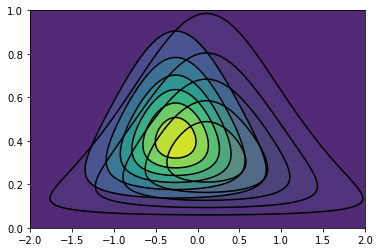

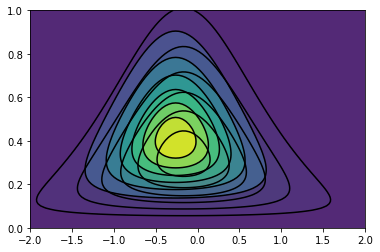

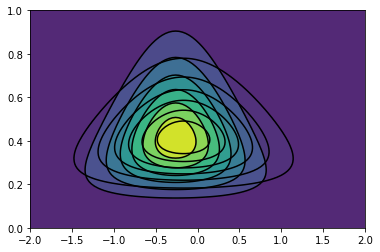

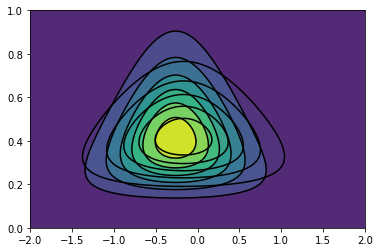

In [1744]:
Et = 0
Np = 5
Xp = np.random.normal(mu_D, sig_D, Np)
a_prior = Np/2
b_prior = (Xp**2).sum() / 2
mu_prior = Xp.sum() / Np
l_prior = Np

#plt.subplot(221)
plt.figure(0)
plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_prior,b_prior,mu_prior,l_prior), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_prior,b_prior,mu_prior,l_prior), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

for i in range(10):
    if Et == 0: Et = a_prior / b_prior
    else: Et = a_vb1 / b_vb1
    mu_vb1 = (Xs.sum() + mu_prior) / (Ns + l_prior)
    l_vb1 = Et * (Ns + l_prior)
    if i == 0:
        #plt.subplot(222)
        plt.figure(1)
        plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_prior,b_prior,mu_vb1, l_vb1), 6, alpha=.75)
        plt.contour(mm, tt, gaussGammaDist(tt, mm, a_prior,b_prior,mu_vb1,l_vb1), 6, colors='black', linewidth=.5)
        #plt.gca().set_aspect('equal')

        plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, alpha=.75)
        plt.contour(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, colors='black', linewidth=.5)
        #plt.gca().set_aspect('equal')

    a_vb1 = a_prior + (Ns+1) / 2
    b_vb1 = b_prior + ((Xs**2).sum() + l_prior*mu_prior**2) / 2
    b_vb1 += (Ns + l_prior) * (mu_vb1**2 + l_vb1**-1) / 2
    b_vb1 += - (Xs.sum() + l_prior*mu_prior) * mu_vb1
    if i == 0:
        #plt.subplot(223)
        plt.figure(2)
        plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_vb1, b_vb1,mu_vb1, l_vb1), 6, alpha=.75)
        plt.contour(mm, tt, gaussGammaDist(tt, mm, a_vb1,b_vb1,mu_vb1,l_vb1), 6, colors='black', linewidth=.5)
        #plt.gca().set_aspect('equal')

        plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, alpha=.75)
        plt.contour(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, colors='black', linewidth=.5)
        #plt.gca().set_aspect('equal')
    


#plt.subplot(224)
plt.figure(3)
plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_vb1, b_vb1,mu_vb1, l_vb1), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_vb1,b_vb1,mu_vb1,l_vb1), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')

plt.contourf(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, alpha=.75)
plt.contour(mm, tt, gaussGammaDist(tt, mm, a_t,b_t,mu_t,l_t), 6, colors='black', linewidth=.5)
#plt.gca().set_aspect('equal')
print(mu_D, sig_D, "＝＝＞", mu_vb1, (b_vb1/a_vb1)**0.5)
print(a_vb1, "<==>", a_t)
print(b_vb1, "<==>", b_t)
print(mu_vb1, "<==>", mu_t)
print(l_vb1, "<==>", l_t)

---

## 変分混合ガウス分布

データサンプリング

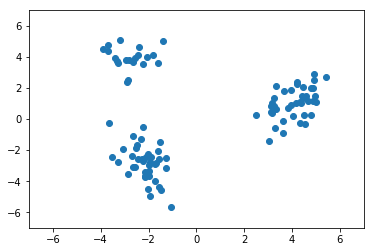

In [1785]:
mu_D = np.array([[-2, -3], [4, 1], [-3, 4]])
lm_D = np.array([[[2, 0.5],[0.5, 1]], [[3, -1],[-1, 2]], [[2, 0],[0, 2]]])
pi_D = np.array([0.4, 0.4, 0.2])
N_D = 100
Xs = np.concatenate([np.random.multivariate_normal(mu_D[i], np.linalg.inv(lm_D[i]), size=int(N_D*pi_D[i])) for i in range(3)])
plt.scatter(Xs[:,0], Xs[:,1])
_=plt.xlim(-7, 7)
_=plt.ylim(-7, 7)

変分Eステップ

In [1746]:
def VEstep(K, Xs, a, m, b, nu, w):
    N_D, D = Xs.shape
    rho = np.zeros((N_D, K))
    r = np.zeros((N_D, K))
    for k in range(K):
        Epi = digamma(a[k]) - digamma(a.sum())
        Elm = np.sum([digamma((nu[k]+1-d)/2) for d in range(1,D+1)]) + D*np.log(2) + np.log(np.linalg.det(w[k]))
        for n, x in enumerate(Xs):
            Emulm = D/b[k]
            Emulm += nu[k] * np.trace(w[k].dot(np.outer(x-m[k], x-m[k])))
            rho[n, k] = np.exp(Epi + Elm/2. - D/2*np.log(2*np.pi) - Emulm/2.)
            
    for n in range(N_D): r[n,:] = rho[n, :] / rho[n, :].sum()
    
    Nk = np.sum(r, axis=0)
    Nk[Nk<1e-10] = 1e-10
    mu_s = np.zeros((K, D))
    var_s = np.zeros((K, D,D))
    for k in range(K):
        if Nk[k] > 1.0e-5:
            mu_s[k] = r[:,k].T.dot(Xs) / Nk[k]
            e = np.array([r[n,k]*np.outer(x-mu_s[k], x-mu_s[k]) for n,x in enumerate(Xs)])
            var_s[k]= e.sum(0)/Nk[k]
    
    return (Nk, mu_s, var_s)

変分Mステップ

In [1747]:
def VMstep(K, Xs, Nk, mu_s, var_s):
    global alpha_prior, beta_prior, nu_prior, mu_prior, W_prior
       
    mu = np.zeros((K, D))
    W = np.array([np.eye(D) for i in range(K)])
    
    alpha = alpha_prior + Nk
    beta = beta_prior + Nk
    nu = nu_prior + Nk
    for k in range(K):
        if Nk[k] > 1.0e-5:
            mu[k] = (beta_prior[k]*mu_prior[k] + Nk[k]*mu_s[k]) / beta[k]
            W[k] = np.linalg.inv(W_prior[k])
            W[k] += Nk[k]*var_s[k]
            W[k] += beta_prior[k]*Nk[k] / (beta_prior[k]+Nk[k]) * np.outer(mu_s[k]-mu_prior[k], mu_s[k]-mu_prior[k])
            W[k] = np.linalg.inv(W[k])
            
    return (alpha, mu, beta, nu, W)

パラメータの初期値を設定

In [1876]:
K = 7
D = 2
alpha_prior = np.zeros(K)
mu_prior = np.zeros((K,D))
beta_prior = np.zeros(K)
nu_prior = np.zeros(K)
W_prior = np.array([np.eye(D) for i in range(K)])

nu_post = np.ones(K)
mu_post = np.random.uniform(-5,5, (K, D))
W_post = np.array([np.eye(D) for i in range(K)])

r_post = 1/K*np.ones((N_D, K))
for k in range(K): r_post[:, k] = np.array([makeMultiGaussian(mu_post[k], np.eye(D))(x) for x in Xs])
for n in range(N_D): r_post[n,:] = r_post[n, :] / r_post[n,:].sum()
Nk = np.zeros(K)
var_s = np.zeros((K, D,D))
mu_s = np.zeros((K, D))
for k in range(K):
    Nk[k] = np.sum(r_post[:,k])
    mu_s[k] = r_post[:,k].T.dot(Xs) / Nk[k]
    e = np.array([r_post[n,k]*np.outer(x-mu_s[k], x-mu_s[k]) for n,x in enumerate(Xs)])
    var_s[k]= e.sum(0)/Nk[k]

事後分布の変分近似を計算

In [1877]:
m = 100
x = np.linspace(-7, 7, m)
y = np.linspace(-7, 7, m)
xx, yy = np.meshgrid(x, y)

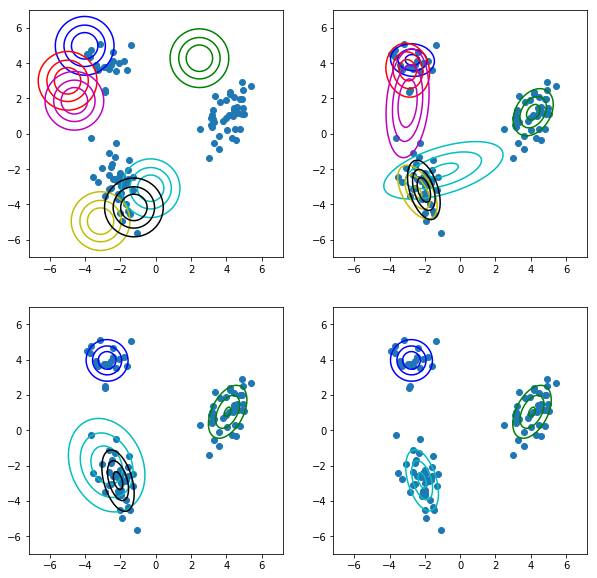

In [1878]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for j in range(4): axes[j].scatter(Xs[:,0], Xs[:,1])
c = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
i = 0
#for k in range(i,i+1):
for k in range(K):
    if Nk[k] > 1.0e-5:
        xy = np.concatenate([xx.reshape(m*m, 1), yy.reshape(m*m,1)], axis=1)
        dist_estimate = makeMultiGaussian(mu_post[k], np.linalg.inv(nu_post[k]*W_post[k]))
        z = np.array([dist_estimate(xy_) for xy_ in xy])
        axes[0].set_aspect('equal', 'datalim')
        axes[0].contour(xx, yy, z.reshape(m,m), 3, colors=c[k], linewidth=.5)
        #plt.contourf(xx, yy, Nk[k]/np.sum(Nk)*z.reshape(m,m), 6, alpha=.75)

step = [1, 5, 20]
for j, s in enumerate(step):
    for i in range(s):
        # M step
        alpha_post, mu_post, beta_post, nu_post, W_post = VMstep(K, Xs, Nk, mu_s, var_s)
        # E step
        Nk, mu_s, var_s = VEstep(K, Xs, alpha_post, mu_post, beta_post, nu_post, W_post)

    for k in range(K):
        if Nk[k] > 1.0e-5:
            xy = np.concatenate([xx.reshape(m*m, 1), yy.reshape(m*m,1)], axis=1)
            dist_estimate = makeMultiGaussian(mu_post[k], np.linalg.inv(nu_post[k]*W_post[k]))
            z = np.array([dist_estimate(xy_) for xy_ in xy])
            axes[j+1].set_aspect('equal', 'datalim')
            axes[j+1].contour(xx, yy, z.reshape(m,m), 3, colors=c[k], linewidth=.5)
            #axes[j+1].set_xlim(-10, 10)
            #axes[j+1].set_ylim(-10, 10)
            #plt.contourf(xx, yy, Nk[k]/np.sum(Nk)*z.reshape(m,m), 6, alpha=.75)

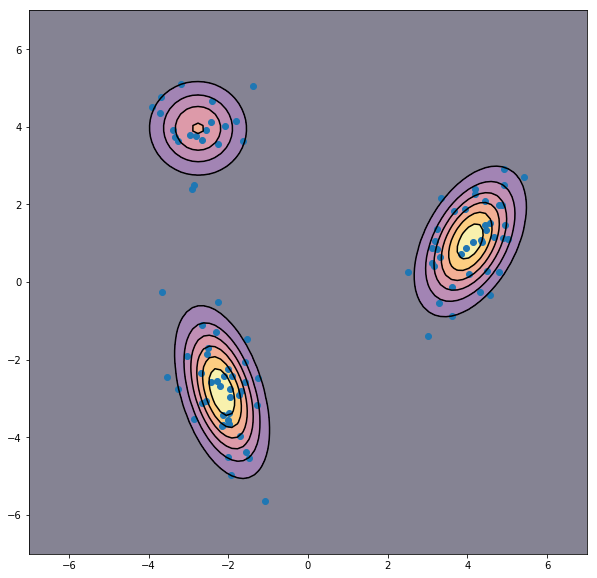

In [1880]:
z = np.zeros(m*m)
for k in range(K):
    xy = np.concatenate([xx.reshape(m*m, 1), yy.reshape(m*m,1)], axis=1)
    dist_estimate = makeMultiGaussian(mu_post[k], np.linalg.inv(nu_post[k]*W_post[k]))
    z += Nk[k]/np.sum(Nk)*np.array([dist_estimate(xy_) for xy_ in xy])

plt.figure(0, figsize=(10,10))
#plt.axes().set_aspect('equal', 'datalim')
plt.contour(xx, yy, z.reshape(m,m), colors="k", linewidth=.2)
plt.contourf(xx, yy, z.reshape(m,m), cmap=plt.cm.inferno, alpha=0.5)
plt.scatter(Xs[:,0], Xs[:,1])

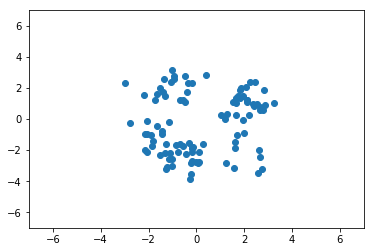

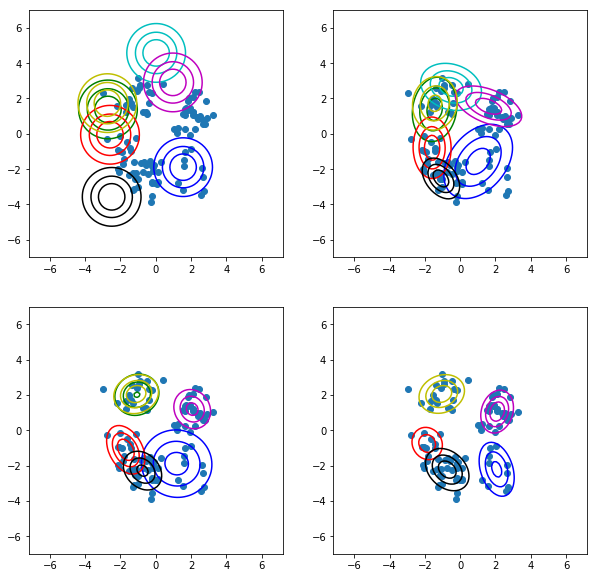

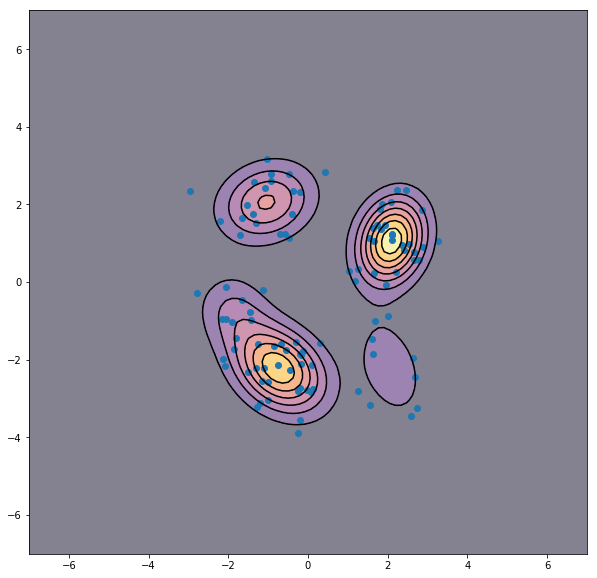

In [1888]:
m = 100
x = np.linspace(-7, 7, m)
y = np.linspace(-7, 7, m)
xx, yy = np.meshgrid(x, y)

mu_D = np.array([[-1, -2], [2, 1], [-1, 2], [2, -2]])
lm_D = np.array([[[2, 0.5],[0.5, 1]], [[3, -1],[-1, 2]], [[2, 0],[0, 2]], [[1, -0.2],[-0.2, 2]]])
pi_D = np.array([0.4, 0.3, 0.2, 0.1])
N_D = 100
Xs = np.concatenate([np.random.multivariate_normal(mu_D[i], np.linalg.inv(lm_D[i]), size=int(N_D*pi_D[i])) for i in range(len(mu_D))])
plt.scatter(Xs[:,0], Xs[:,1])
_=plt.xlim(-7, 7)
_=plt.ylim(-7, 7)

K = 7
D = 2
alpha_prior = np.zeros(K)
mu_prior = np.zeros((K,D))
beta_prior = np.zeros(K)
nu_prior = np.zeros(K)
W_prior = np.array([np.eye(D) for i in range(K)])

nu_post = np.ones(K)
mu_post = np.random.uniform(-5,5, (K, D))
W_post = np.array([np.eye(D) for i in range(K)])

r_post = 1/K*np.ones((N_D, K))
for k in range(K): r_post[:, k] = np.array([makeMultiGaussian(mu_post[k], np.eye(D))(x) for x in Xs])
for n in range(N_D): r_post[n,:] = r_post[n, :] / r_post[n,:].sum()
Nk = np.zeros(K)
var_s = np.zeros((K, D,D))
mu_s = np.zeros((K, D))
for k in range(K):
    Nk[k] = np.sum(r_post[:,k])
    mu_s[k] = r_post[:,k].T.dot(Xs) / Nk[k]
    e = np.array([r_post[n,k]*np.outer(x-mu_s[k], x-mu_s[k]) for n,x in enumerate(Xs)])
    var_s[k]= e.sum(0)/Nk[k]
    
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for j in range(4): axes[j].scatter(Xs[:,0], Xs[:,1])
c = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
i = 0
#for k in range(i,i+1):
for k in range(K):
    if Nk[k] > 1.0e-5:
        xy = np.concatenate([xx.reshape(m*m, 1), yy.reshape(m*m,1)], axis=1)
        dist_estimate = makeMultiGaussian(mu_post[k], np.linalg.inv(nu_post[k]*W_post[k]))
        z = np.array([dist_estimate(xy_) for xy_ in xy])
        axes[0].set_aspect('equal', 'datalim')
        axes[0].contour(xx, yy, z.reshape(m,m), 3, colors=c[k], linewidth=.5)
        #plt.contourf(xx, yy, Nk[k]/np.sum(Nk)*z.reshape(m,m), 6, alpha=.75)

step = [1, 5, 20]
for j, s in enumerate(step):
    for i in range(s):
        # M step
        alpha_post, mu_post, beta_post, nu_post, W_post = VMstep(K, Xs, Nk, mu_s, var_s)
        # E step
        Nk, mu_s, var_s = VEstep(K, Xs, alpha_post, mu_post, beta_post, nu_post, W_post)

    for k in range(K):
        if Nk[k] > 1.0e-5:
            xy = np.concatenate([xx.reshape(m*m, 1), yy.reshape(m*m,1)], axis=1)
            dist_estimate = makeMultiGaussian(mu_post[k], np.linalg.inv(nu_post[k]*W_post[k]))
            z = np.array([dist_estimate(xy_) for xy_ in xy])
            axes[j+1].set_aspect('equal', 'datalim')
            axes[j+1].contour(xx, yy, z.reshape(m,m), 3, colors=c[k], linewidth=.5)
            #axes[j+1].set_xlim(-10, 10)
            #axes[j+1].set_ylim(-10, 10)
            #plt.contourf(xx, yy, Nk[k]/np.sum(Nk)*z.reshape(m,m), 6, alpha=.75)
            
z = np.zeros(m*m)
for k in range(K):
    xy = np.concatenate([xx.reshape(m*m, 1), yy.reshape(m*m,1)], axis=1)
    dist_estimate = makeMultiGaussian(mu_post[k], np.linalg.inv(nu_post[k]*W_post[k]))
    z += Nk[k]/np.sum(Nk)*np.array([dist_estimate(xy_) for xy_ in xy])

plt.figure(0, figsize=(10,10))
#plt.axes().set_aspect('equal', 'datalim')
plt.contour(xx, yy, z.reshape(m,m), colors="k", linewidth=.2)
plt.contourf(xx, yy, z.reshape(m,m), cmap=plt.cm.inferno, alpha=0.5)
plt.scatter(Xs[:,0], Xs[:,1])